In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import re
import spacy
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Load Training Data
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("512_each_statements_nonstatements_chunks.xlsx")

# Identify text column, force string
text_col = 'text' if 'text' in df.columns else df.columns[0]
df[text_col] = df[text_col].astype(str)

# Ensure label exists and is 0/1
assert "label" in df.columns, "Expected a 'label' column with 0/1."
texts = df[text_col].tolist()
y = np.array(df["label"].tolist(), dtype=int)

# Load Models
nlp = spacy.load("en_core_web_sm")
sbert = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

Saving 512_each_statements_nonstatements_chunks.xlsx to 512_each_statements_nonstatements_chunks (4).xlsx


In [ ]:
# Feature Engineering
def extract_features(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]

    return {
        "starts_with_modal": int(bool(re.match(r"^(should|must|can|will|would|shall)\b", text.lower()))),
        "contains_question_mark": int("?" in text),
        "length_tokens": len(text.split()),
        "contains_numbers": int(bool(re.search(r"\d", text))),
        "starts_with_amendment_term": int(bool(re.match(r"^(amendment|clause|section)\b", text.lower()))),
        "has_actor_reference": int(bool(re.search(r"\b(we|government|minist(er|ry))\b", text.lower()))),
        "has_modal_verb": int(bool(re.search(r"\b(should|must|can|could|might|will|shall|would|may)\b", text.lower()))),
        "has_adj_or_adv": int("ADJ" in pos_tags or "ADV" in pos_tags)
    }


In [ ]:
# Extract Features
feature_df = pd.DataFrame([extract_features(t) for t in texts])
feature_cols = feature_df.columns.tolist()

# SBERT Embeddings
embeddings = sbert.encode(texts, show_progress_bar=True)
embeddings = np.asarray(embeddings, dtype=np.float32)

# L2-normalise embeddings
embeddings = normalize(embeddings, norm="l2")

# Standardise Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df.values.astype(np.float32))

# Combine
X_combined = np.hstack([embeddings, features_scaled])

# CV Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining Scoring Metrics
scoring = {
    "accuracy": "accuracy",
    "precision_statement": make_scorer(precision_score, pos_label=1),
    "recall_statement": make_scorer(recall_score, pos_label=1),
    "f1_statement": make_scorer(f1_score, pos_label=1),
    "f1_macro": "f1_macro",
}


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Making the MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256,),
    activation="relu",
    solver="adam",
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Cross Validated Metrics
print("\nRunning 5-fold cross-validation...")
cv_results = cross_validate(
    mlp, X_combined, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
)

print("\nCV mean ± std (5-fold):")
for k in ["test_accuracy", "test_precision_statement", "test_recall_statement", "test_f1_statement", "test_f1_macro"]:
    mean_k = np.mean(cv_results[k])
    std_k = np.std(cv_results[k])
    print(f"{k.replace('test_', ''):>22}: {mean_k:.3f} ± {std_k:.3f}")

# Out of fold predictions and confusion matrix
print("\nGenerating out-of-fold predictions for confusion matrix & error inspection...")
y_pred_oof = cross_val_predict(mlp, X_combined, y, cv=cv, n_jobs=-1)

cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\nOut-of-fold confusion matrix (rows=true, cols=pred):")
print(cm)
print(f"\nFalse positives (non-statement → statement): {fp}")
print(f"False negatives (statement → non-statement): {fn}")

print("\nClassification report (OOF):")
print(classification_report(y, y_pred_oof, target_names=["non-statement", "statement"]))



Running 5-fold cross-validation...

CV mean ± std (5-fold):
              accuracy: 0.859 ± 0.020
   precision_statement: 0.832 ± 0.029
      recall_statement: 0.902 ± 0.032
          f1_statement: 0.865 ± 0.019
              f1_macro: 0.859 ± 0.020

Generating out-of-fold predictions for confusion matrix & error inspection...

Out-of-fold confusion matrix (rows=true, cols=pred):
[[418  94]
 [ 50 462]]

False positives (non-statement → statement): 94
False negatives (statement → non-statement): 50

Classification report (OOF):
               precision    recall  f1-score   support

non-statement       0.89      0.82      0.85       512
    statement       0.83      0.90      0.87       512

     accuracy                           0.86      1024
    macro avg       0.86      0.86      0.86      1024
 weighted avg       0.86      0.86      0.86      1024



In [ ]:
# Preview a few false positives / negatives
false_positives = [text for text, true, pred in zip(texts, y, y_pred_oof) if true == 0 and pred == 1]
false_negatives = [text for text, true, pred in zip(texts, y, y_pred_oof) if true == 1 and pred == 0]

print("\n=== A few False Positives (pred=statement, true=non-statement) ===")
for i, fp_text in enumerate(false_positives[:10], start=1):
    print(f"\n🟠 False Positive {i}:\n{fp_text}")

print("\n=== A few False Negatives (pred=non-statement, true=statement) ===")
for i, fn_text in enumerate(false_negatives[:10], start=1):
    print(f"\n🔵 False Negative {i}:\n{fn_text}")



=== A few False Positives (pred=statement, true=non-statement) ===

🟠 False Positive 1:
This new clause would establish a clearer right to strike and remove provisions from the Trade Union and Labour Relations (Consolidation) Act 1992 that make strike action unlawful on the grounds that it turns out (retrospectively) that the action the worker took was unofficial.

🟠 False Positive 2:
It is little surprise that, under Labour, the economy is flatlining.

🟠 False Positive 3:
The Government should be able to support these amendments.

🟠 False Positive 4:
Currently, when an individual wishes to take the option of making themselves bankrupt, they must complete a paper petition and present it to their local court.

🟠 False Positive 5:
Can you advise whether Conservative Members who received money from businesses affected by this legislation should make a declaration in the same way that we trade unionists do?

🟠 False Positive 6:
With regard to complex cases, will the Minister explain just 

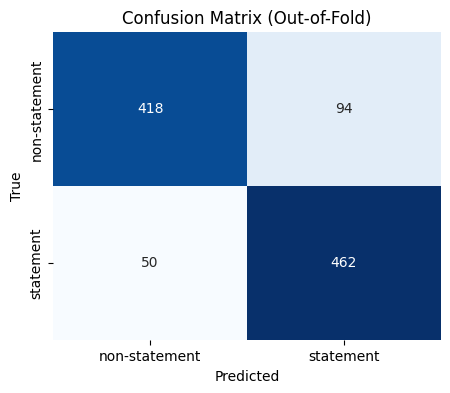

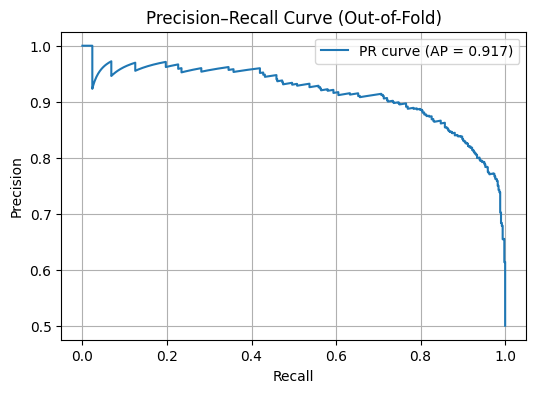

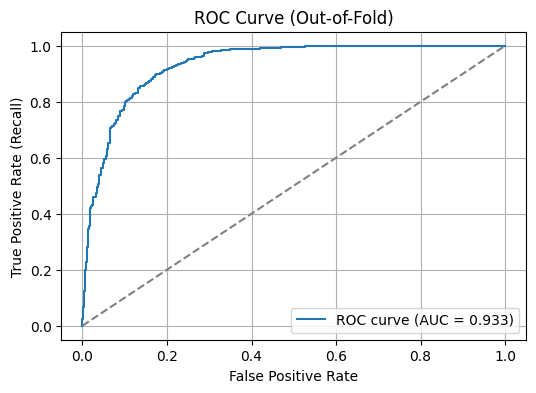

In [ ]:
# Visualising Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score,
    roc_curve, auc
)

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["non-statement","statement"],
            yticklabels=["non-statement","statement"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Out-of-Fold)")
plt.show()

# Precision-Recall Curve
y_scores = cross_val_predict(mlp, X_combined, y, cv=cv, method="predict_proba")[:,1]  # probability of class=1
prec, rec, thresh = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Out-of-Fold)")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresh = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"--", color="grey")  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Out-of-Fold)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Save the trained model
mlp.fit(X_combined, y)
joblib.dump(
    {"model": mlp, "scaler": scaler, "feature_cols": feature_cols},
    "MLP_statement_segmenter.joblib"
)


['MLP_statement_segmenter.joblib']